#복습 과제

## **Problem 1**

### 1) Data augmentation과 Dropout의 개념에 대해 서술하고, 각각 Overfitting의 방지에 어떻게 도움이 되는지 서술하시오.

- Data augmentation : 학습 데이터를 불리는 작업
    - filp, shift등으로 데이터를 불려 overfitting 방지

- Drop Out : 몇몇 뉴런들을 생략하여 학습하는 작업
    - 특정 feature가 왜곡이 되었거나 특정 feature에 의존하지 않게 함으로써
    overfitting 방지

### 2) Normalization이 optimization에 어떻게 도움을 줄 수 있는지 서술하시오.

- scale이 균일하지 않아 high curvature 혹은 less curvature에 따른 Gradient 값이 요동치는 것을 방지

### 3) Batch Normalization이 본래 해결하고자 의도된 문제가 무엇이며 실제 Batch Normalization이 optimization에 어떻게 도움을 주는지 서술하시오.

- hidden layer에도 normalization을 적용 
    - Fast convergence
    - Achieve same accuracy faster
    - Less sensitive to weight initialization
    - Regularization effect, better performance 등등

### 4) Inductive bias의 개념에 대해 설명하고 Fully connected layer와 Convolutional layer의 Inductive bias를 각각의 architecture에 기반하여 설명하시오. 나아가 Convolution layer가 이미지 데이터의 학습에 효과적인 이유를 서술하시오.

- fully connected와 달리 근처에 있는 데이터의 값으로 연결
- 한 부분의 국소적인 관계가 다른 곳에서도 통함 


### 5) Pooling layer를 사용하는 이유와 Convolution layer에서 stride를 키워 dimension을 줄이는 경우와의 차이를 논하시오. 

- stride를 키우게 될 경우 parameter의 값이 증가하는데 반해, 
 Pooling layer를 사용하는 이유는
    - 배워야 하는 parameter가 0이라 computational cost가 없는 상태로 dimensionality를 줄일 수 있음
    - overfitting 방지



## **Problem 2**

###1) 다음의 그래프를 보고 overfitting된 모델을 모두 고르고 그 이유를 서술하시오. 또한 이를 개선할 수 있는 방안들에 대해 간략히 서술하시오.

- model 1, model 2
    - overfitting 된 모델은 accuracy가 점차 상승하다가 epoch가 많아질수록 떨어지는 모습을 보임

    - 개선 방안
        - overfitting 되기 전 Early Stopping 설정
        


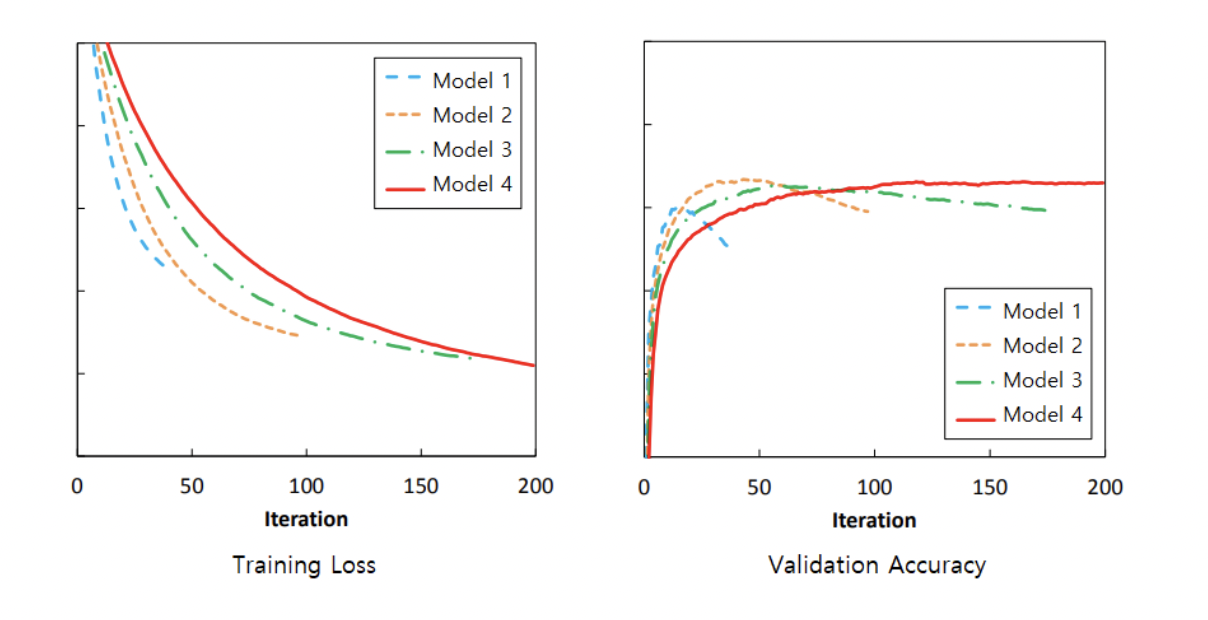

### 2) 데이터 X에 대해 필터 F를 사용하여 Convolution 연산을 수행하시오. 단, Stride는 1로 설정하고 Padding은 Convolution 이후에 dimension을 X와 동일하게 유지할 수 있도록 추가하시오.

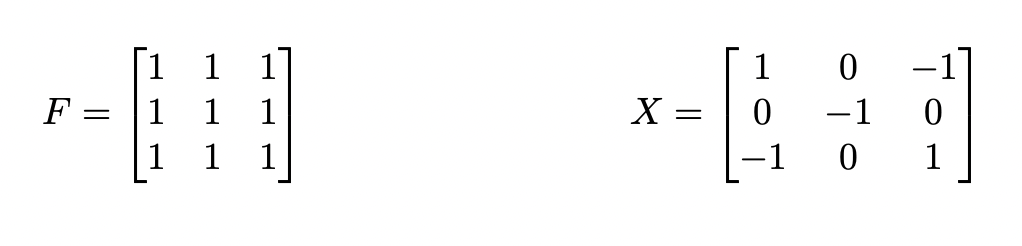

In [ ]:
out = [0 -1 -2
       -1 -1 -1
       -2 -1 0]

.

.

.

#실습 과제

수업시간에 배운 CNN의 구조와 다양한 방법론(optimizer, lr scheduler, dropout, batchnorm 등)을 활용하여 본인만의 Convolutional Neural Network를 구축하여 75% 이상의 accuracy를 달성하시오. (Drive 경로 및 GPU 설정 이후 Exercise 섹션만 수정하면 됨)

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
파일 위치에 맞게 디렉토리 변경
"""
%cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import torch
DEVICE = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

Using PyTorch version: 1.12.1+cu113, Device: cuda


In [ ]:
#@title Utils (수정 필요 x)

import cv2
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

def train(model, train_loader, optimizer):

    model.train()
    tqdm_bar = tqdm(enumerate(train_loader))
    for batch_idx, (image, label) in tqdm_bar:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))


def evaluate(model, test_loader):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

def gaussian_smoothing(image, filter_size=3, sigma=1.0):

    center = (filter_size-1)/2
    gaussian_filter = np.zeros((filter_size, filter_size))
    for row in range(filter_size):
        for col in range(filter_size):
            gaussian_filter[row, col] = np.exp((-(row-center) ** 2 - (col-center) ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)
    gaussian_filter = gaussian_filter / np.sum(gaussian_filter)
    image = cv2.filter2D(image, -1, gaussian_filter)
    return image

def color_jitter(image):

    image = cv2.convertScaleAbs(image, alpha=1.5, beta=20)
    return image

class CustomDataset(Dataset):
    def __init__(self, train, prob=0.5, data_dir="./CIFAR_10"):

        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.prob = prob

    def __len__(self):

        return len(self.data)
    
    def __getitem__(self, idx):

        return self.data[idx]
    
    def transform(self, image):

        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if np.random.uniform() < self.prob:
          a = np.random.choice(2,1)
          if a == 0:
            image = gaussian_smoothing(image)
          else:
            image = color_jitter(image)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def collate_fn(self, data):

        batch_x, batch_y = [], []

        for x, y in data:
          x = np.array(x) 
          x = self.transform(x) 
          x = x / 255.0 
          x = np.array([x[:,:,i] for i in range(3)]) 
          batch_x.append(x)
          batch_y.append(y)
        batch_x = torch.FloatTensor(batch_x) 
        batch_y = torch.LongTensor(batch_y) 

        return batch_x, batch_y

In [ ]:
#@title Dataloader (수정 필요 x)

train_dataset = CustomDataset(train=True, prob=0.5)
test_dataset = CustomDataset(train=False, prob=0.5)

BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, 
                         collate_fn=test_dataset.collate_fn)

Files already downloaded and verified
Files already downloaded and verified


## Exercise

In [ ]:
class ConvNet(nn.Module):

    def __init__(self):

        super(ConvNet, self).__init__()

        ### COMPLETE HERE ###
        #예시코드
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1)
        self.batch2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, padding=1)
        self.batch3 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(4*4*512, 1096)
        self.fc2 = nn.Linear(1096, 256)
        self.fc3 = nn.Linear(256, 10)


        ### COMPLETE HERE ###
    
    def forward(self, x):

        ### COMPLETE HERE ###
        #예시코드
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        ### COMPLETE HERE ###

        return x

In [ ]:
model = ConvNet().to(DEVICE)

### COMPLETE HERE ###
# 예시코드
EPOCHS = 10
lr = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
### COMPLETE HERE ###

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: ConvNet, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: ConvNet, 	Test Loss: 0.0249, 	Test Accuracy: 41.28 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: ConvNet, 	Test Loss: 0.0189, 	Test Accuracy: 57.01 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: ConvNet, 	Test Loss: 0.0167, 	Test Accuracy: 63.80 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: ConvNet, 	Test Loss: 0.0167, 	Test Accuracy: 63.29 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: ConvNet, 	Test Loss: 0.0143, 	Test Accuracy: 69.33 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 6], 	Model: ConvNet, 	Test Loss: 0.0145, 	Test Accuracy: 67.71 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 7], 	Model: ConvNet, 	Test Loss: 0.0159, 	Test Accuracy: 66.40 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 8], 	Model: ConvNet, 	Test Loss: 0.0124, 	Test Accuracy: 73.92 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 9], 	Model: ConvNet, 	Test Loss: 0.0131, 	Test Accuracy: 72.35 % 



0it [00:00, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]


[EPOCH: 10], 	Model: ConvNet, 	Test Loss: 0.0114, 	Test Accuracy: 76.92 % 

